In [77]:
INPUT_DIRECTORY = "../dataset"

# Importing Libraries

In [78]:
import os
import base64
import requests
import numpy as np
import pandas as pd
import itertools
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from scipy.interpolate import spline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dropout, Flatten
from keras import callbacks
from keras.callbacks import EarlyStopping, CSVLogger
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score,classification_report

# Function Definition

In [79]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_



# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)




def load_data():
    filename = "all_attack_sampled_dataset.csv"
    file = os.path.join(INPUT_DIRECTORY,filename)
    df1 = pd.read_csv(file)
    return df1

def oversample(dfx):
    max_size = dfx ['SubLabel'].value_counts().max()
    lst = [dfx ]
    for class_index, group in dfx .groupby('SubLabel'):
        lst.append(group.sample(max_size-len(group), replace=True))
    dfx_new = pd.concat(lst)
    return dfx_new

def preprocess(df):
    print("Total number of features : ",len(df.columns))
    print("\n----Dropping features---")
    
    drop_columns = ['Timestamp','Src IP','Dst IP','Src Port','Flow ID']
    df.drop(drop_columns,inplace=True,axis=1)
    
    print("Number of features : ",len(df.columns))
    print("\n----Encoding categorical data---")
    
    df.loc[df['SubLabel']=='Normal', 'SubLabel'] = 0

    df.loc[df['SubLabel']=='Port Scan', 'SubLabel'] = 1
    df.loc[df['SubLabel']=='TCP SYN Scan', 'SubLabel'] = 1

    df.loc[df['SubLabel']=='DOS goldeneye', 'SubLabel'] = 5
    df.loc[df['SubLabel']=='DOS Slowloris', 'SubLabel'] = 5
    df.loc[df['SubLabel']=='ICMP Flood', 'SubLabel'] = 2
    df.loc[df['SubLabel']=='Push ACK Flood', 'SubLabel'] = 2
    df.loc[df['SubLabel']=='SYN FIN Flood', 'SubLabel'] = 2
    df.loc[df['SubLabel']=='UDP Flood', 'SubLabel'] = 5
    
    df.loc[df['SubLabel']=='SSH BruteForce', 'SubLabel'] = 3
    
    df.loc[df['SubLabel']=='Malware Infiltration', 'SubLabel'] = 4


    
    df.loc[df['SubLabel']=='FTP Bounce Scan', 'SubLabel'] = 5
    df.loc[df['SubLabel']=='Host Scan', 'SubLabel'] = 5
    df.loc[df['SubLabel']=='Xmas Scan', 'SubLabel'] = 5
    df.loc[df['SubLabel']=='ACK Scan', 'SubLabel'] = 5
    df.loc[df['SubLabel']=='FIN Scan', 'SubLabel'] = 5 
    df.loc[df['SubLabel']=='FTP Bruteforce', 'SubLabel'] = 5
    df.loc[df['SubLabel']=='MySql BruteForce', 'SubLabel'] = 5
    
   
    df = df.drop(df[(df.SubLabel!= 0) & (df.SubLabel!= 1 )& (df.SubLabel!= 2)&(df.SubLabel!= 3)&(df.SubLabel!= 4)].index)

    
    
    # replacing normal by 0 and threat by 1 
    df.loc[df['Label']=='Normal', 'Label'] = 0
    df.loc[df['Label']=='Attack', 'Label'] = 1
   
     
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def evaluate_multiclass(y_pred, y_eval, history):
    #evaluation
    from sklearn import metrics
    print(metrics.classification_report(y_eval,y_pred, target_names=['Normal', 'Scan','DOS','Bruteforce','Malware']))
    print(f"Accuracy:{accuracy_score(y_eval,y_pred)*100}%")
    
    # Plot normalized confusion matrix
    cm = confusion_matrix(y_eval, y_pred)
    class_names = ['Normal', 'Scan','DOS','Bruteforce','Malware']
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(cm, classes=class_names, normalize=False,title='CONFUSION MATRIX \n\n Multiclass Classification \n')
    plt.show()

    #plot model loss
    plt.figure(figsize=(5,5))
    plt.plot(history.history['loss'], linewidth=2, label='Train',color = 'Green')
    plt.plot(history.history['val_loss'], linewidth=2, label='Valid',color ='Brown')
    plt.legend(loc='upper right')
    plt.title('MODEL LOSS CURVE')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

    
def evaluate(y_pred, y_eval, history, Attack_name):
    #evaluation
    print(f"Accuracy:{accuracy_score(y_eval,y_pred)*100}%")
    print(f"Precison:{precision_score(y_eval,y_pred)*100}")
    print(f"Recall:{recall_score(y_eval,y_pred)*100}")
    print(f"F1-Score:{f1_score(y_eval, y_pred) *100}")
    

    # Plot normalized confusion matrix
    cm = confusion_matrix(y_eval, y_pred)
    class_names = ['Normal',Attack_name]
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cm, classes=class_names, normalize=False,title=f'CONFUSION MATRIX \n Normal vs {Attack_name} \n') 
    plt.show()

    # Print ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_eval, y_pred,pos_label=1)
    n = 20
    x_interp = np.linspace(0,0.1,n+1)
    y_interp = spline(fpr, tpr, x_interp, order=1)
    plt.figure(figsize=(5,5))
    plt.title(f'ROC CURVE \n {Attack_name} Classification \n')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(x_interp,y_interp)
    plt.show() 
#     print(x_interp, y_interp, thresholds)

    # Print AUC
    auc = np.trapz(tpr,fpr)
    print('AUC:', auc)
    
    

# Model definitions

In [80]:
# Dense Neural Network
#Dense Neural Network

def dnnmodel(x,y):
    
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1000)


    print("#### Training and Testing the model ####")
    # Create neural net
    model = Sequential()
    model.add(Dense(54, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(y.shape[1],activation='softmax'))
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
    history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
    
    #save model
#     model.save("../models/modeldnnattack.hdf5")
    print("Saved model to disk")
    
    #predict label
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis=1)
    y_test = np.argmax(y_test,axis=1)
    
    return y_pred ,  y_test, history

#Lstm NeuraL Network

def dnnmodel_multiclass():
    x = df1.iloc[:,0:78].values  
    y = df1.iloc[:,78:83].values
    
    #scale using minmaxscalar
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1000)


    print("#### Dense Neural Network ####")
    # Create neural net
    model = Sequential()
    model.add(Dense(x.shape[1], input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(y.shape[1],activation='softmax'))
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=1, mode='auto')
    history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
    
    #save model
    model.save("../models/modeldnnoversample.hdf5")
    print("Saved model to disk")
    
    #predict label
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis=1)
    y_eval = np.argmax(y_test,axis=1)
    
    #model summary
    print(model.summary())
    
    return y_pred ,  y_eval, history


def dnnmodel_multiclassf():
    x = df1.iloc[:,0:35].values  
    y = df1.iloc[:,35:41].values
    
    #scale using minmaxscalar
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1000)


    print("#### Dense Neural Network ####")
    # Create neural net
    model = Sequential()
    model.add(Dense(x.shape[1], input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(y.shape[1],activation='softmax'))
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
    
    #save model
    model.save("../models/modeldnnoversample35.hdf5")
    print("Saved model to disk")
    
    #predict label
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis=1)
    y_eval = np.argmax(y_test,axis=1)
    
    #model summary
    print(model.summary())
    
    return y_pred ,  y_eval, history



#Lstm NeuraL Network
def Lstm_model_multiclass():
    x = df1.iloc[:,0:78].values  
    y = df1.iloc[:,78:83].values
    
    # Feature Scaling
    sc = StandardScaler()  
    x = sc.fit_transform(x)  

     # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1000)
    
    
    # reshape input to be [samples, time steps, features]
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    
    batch_size = 64
    
    # 1. define the network
    model = Sequential()
    model.add(LSTM(64,input_dim=78, return_sequences=True))  
    model.add(LSTM(64, return_sequences=False)) 
    model.add(Dense(y.shape[1]))
    model.add(Activation('sigmoid'))
    
    #model summary
    print(model.summary())

    # try using different optimizers and different optimizer configs
    model.compile(loss='binary_crossentropy',optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
   
    #save model
    model.save("../models/modeltestLSTM.hdf5")
    
    #predict label
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis=1)
    y_test = np.argmax(y_test,axis=1)
    
     
    return y_pred ,  y_test, history


def dnnmodel_binary(df):
    
    x,y =  to_xy(df,'Label')
    
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1000)


    print("#### Training and Testing the model ####")
    # Create neural net
    model = Sequential()
    model.add(Dense(54, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(y.shape[1],activation='softmax'))
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
    history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
    
    #save model
    model.save("../models/modeltestdnnbinary.hdf5")
    print("Saved model to disk")
    
    #predict label
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis=1)
    y_test = np.argmax(y_test,axis=1)
    
    return y_pred ,  y_test, history



# Loading Data

In [81]:
df = load_data()

#Sample view of dataset
df.head()


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,SubLabel
0,192.168.10.9-110.44.113.201-59647-53-17,192.168.10.9,59647,110.44.113.201,53,17,26/07/2019 12:32:22 PM,63959,0,2,...,0.0,0.0,0,0,0.000000e+00,0.000000e+00,0,0,Normal,Normal
1,192.168.10.100-8.8.8.8-54856-53-17,192.168.10.100,54856,8.8.8.8,53,17,22/07/2019 02:29:44 PM,103048,0,2,...,0.0,0.0,0,0,0.000000e+00,0.000000e+00,0,0,Normal,Normal
2,192.168.10.2-192.168.10.6-80-27052-6,192.168.10.6,27052,192.168.10.2,80,6,26/07/2019 03:28:33 PM,34937948,1,1,...,0.0,0.0,0,0,0.000000e+00,0.000000e+00,0,0,Attack,SYN FIN Flood
3,185.82.212.199-192.168.10.9-80-32860-6,192.168.10.9,32860,185.82.212.199,80,6,26/07/2019 12:26:03 PM,64812032,6,1,...,7087197.0,0.0,7087197,7087197,1.924161e+07,1.289346e+07,33406563,8189633,Normal,Normal
4,192.168.10.7-239.255.255.250-0-0-0,192.168.10.7,0,239.255.255.250,0,0,22/07/2019 02:32:46 PM,119825401,6,1,...,0.0,0.0,0,0,2.380801e+07,1.594520e+07,48978764,7989707,Normal,Normal


# Statistical Summary

In [82]:
df.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,70456.000000,70456.000000,70456.000000,7.045600e+04,70456.000000,70456.000000,7.045600e+04,7.045600e+04,70456.000000,70456.000000,...,70456.000000,70456.0,7.045600e+04,7.045600e+04,7.045600e+04,7.045600e+04,7.045600e+04,7.045600e+04,7.045600e+04,7.045600e+04
mean,42656.019445,13066.237978,8.899285,1.698287e+07,33.167523,34.191609,2.048875e+04,2.285805e+04,140.938600,7.777336,...,16.831384,0.0,5.205629e+05,1.116933e+05,6.421701e+05,4.409133e+05,6.342716e+06,9.650414e+05,7.228971e+06,5.572509e+06
std,19711.668361,20692.644673,4.909369,3.180906e+07,1080.697703,1047.846169,7.037731e+05,4.622271e+05,411.583824,42.708553,...,445.823474,0.0,2.497573e+06,8.709950e+05,2.887033e+06,2.370201e+06,1.364493e+07,5.194512e+06,1.583098e+07,1.281572e+07
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,37191.250000,68.000000,6.000000,3.469750e+03,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,51413.000000,443.000000,6.000000,4.362390e+05,1.000000,2.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,55885.000000,20031.000000,17.000000,1.132589e+07,3.000000,4.000000,9.600000e+01,1.870000e+02,54.000000,0.000000,...,1.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000496e+06,0.000000e+00,6.000520e+06,5.997663e+06
max,65535.000000,65530.000000,17.000000,1.200000e+08,172161.000000,171867.000000,4.468043e+07,4.455589e+07,20272.000000,1360.000000,...,30825.000000,0.0,1.099361e+08,5.162984e+07,1.099361e+08,1.099361e+08,1.199999e+08,7.402181e+07,1.199999e+08,1.199999e+08


# Label Distribution of Dataset

In [83]:
print('Label distribution of data set:')
print(df['SubLabel'].value_counts())
print()


Label distribution of data set:
Normal                  45048
DOS goldeneye            2860
FTP Bruteforce           2708
FTP Bounce Scan          2258
SYN FIN Flood            2156
Host Scan                2107
SSH BruteForce           1991
Port Scan                1966
ACK Scan                 1819
UDP Flood                1382
MySql BruteForce         1373
Push ACK Flood           1311
TCP SYN Scan             1000
Xmas Scan                 997
FIN Scan                  997
Malware Infiltration      449
DOS Slowloris              31
ICMP Flood                  3
Name: SubLabel, dtype: int64



# Step 1: Preprocessing and Encoding data

In [84]:
print("Shape of data:",df.shape)
preprocess(df)

#changing data type
df['Flow Byts/s'] = df['Flow Byts/s'].astype('float32')
df['Flow Pkts/s'] = df['Flow Pkts/s'].astype('float32')
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df = df.sample(frac=1).reset_index(drop=True)

df.head()


Shape of data: (70456, 85)
Total number of features :  85

----Dropping features---
Number of features :  80

----Encoding categorical data---


,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,SubLabel
0,80,17,44439236,1,1,0,0,0,0,0.0,...,0.0,0.0,0,0,44439236.0,0.0,44439236,44439236,Attack,5
1,6969,6,15420885,4,1,0,0,0,0,0.0,...,7225231.0,0.0,7225231,7225231,8195654.0,0.0,8195654,8195654,Normal,0
2,53,17,57810,0,2,0,154,0,0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,Normal,0
3,53,17,8144,1,3,33,419,33,33,33.0,...,0.0,0.0,0,0,0.0,0.0,0,0,Normal,0
4,53,6,2904,0,2,0,0,0,0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,Normal,0


In [85]:
df.shape
print(df['SubLabel'].value_counts())

0    44769
5    16532
2     3470
1     2966
3     1991
4      449
Name: SubLabel, dtype: int64


## Split Dataset into 5 datasets for every attack category

In [86]:
df_original = df.copy()
df = oversample(df)
df1=df.copy()
df= df.sample(frac=1).reset_index(drop=True) 
df1= df1.sample(frac=1).reset_index(drop=True)
df1.drop(['Label'], inplace = True , axis=1)
df.drop(['SubLabel'], inplace = True , axis=1)

In [87]:
#Scan
df_Scan = df1.drop(df1[(df1.SubLabel!= 1) & (df1.SubLabel!= 0)].index)
#DOS attack
df_DOS = df1.drop(df1[(df1.SubLabel!= 2) & (df1.SubLabel!= 0) ].index)
#BruteForce
df_SSHBruteForce = df1.drop(df1[(df1.SubLabel!= 3) & (df1.SubLabel!= 0) ].index)
#Malware
df_Malware = df1.drop(df1[(df1.SubLabel!= 4) & (df1.SubLabel!= 0) ].index)


In [88]:
print(df1['SubLabel'].value_counts())

5    44769
4    44769
3    44769
2    44769
1    44769
0    44769
Name: SubLabel, dtype: int64


# Step 2: Feature Scaling:

In [89]:
# Split dataframes into X & Y
# assign X as a dataframe of feautures and Y as a series of outcome variables

X_Scan,Y_Scan = to_xy(df_Scan,'SubLabel')
Y_ScanF = df_Scan.SubLabel

X_DOS,Y_DOS = to_xy(df_DOS,'SubLabel')
Y_DOSF = df_DOS.SubLabel

X_SSHBruteForce,Y_SSHBruteForce = to_xy(df_SSHBruteForce,'SubLabel')
Y_SSHBruteForceF = df_SSHBruteForce.SubLabel

X_Malware,Y_Malware = to_xy(df_Malware,'SubLabel')
Y_MalwareF = df_Malware.SubLabel



## Use StandardScaler() to scale the dataframes

In [90]:
scaler1 = preprocessing.StandardScaler().fit(X_Scan)
X_Scan = scaler1.transform(X_Scan) 

scaler2 = preprocessing.StandardScaler().fit(X_DOS)
X_DOS = scaler2.transform(X_DOS) 

scaler3 = preprocessing.StandardScaler().fit(X_SSHBruteForce)
X_SSHBruteForce = scaler3.transform(X_SSHBruteForce) 

scaler4 = preprocessing.StandardScaler().fit(X_Malware)
X_Malware = scaler4.transform(X_Malware) 



# Step 3: Feature Selection:


## 1. Univariate Feature Selection using ANOVA F-test

In [91]:
from sklearn.feature_selection import SelectPercentile, f_classif
np.seterr(divide='ignore', invalid='ignore');
colNames=list(df1)

selector=SelectPercentile(f_classif, percentile=50)
X_newScan = selector.fit_transform(X_Scan,Y_ScanF)
X_newScan.shape


/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [31 33 34 49 50 51 56 57 58 59 60 61 66 69] are constant.
  UserWarning)


(89538, 39)

## Get the features that were selected: Port Scan

In [92]:
true=selector.get_support()
newcolindex_Scan=[i for i, x in enumerate(true) if x]
newcolname_Scan=list( colNames[i] for i in newcolindex_Scan )
newcolname_Scan

['Protocol',
 'Flow Duration',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'SYN Flag Cnt',
 'ACK Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Init Bwd Win Byts',
 'Active Mean',
 'Active Max',
 'Active Min',
 'Idle Mean',
 'Idle Max',
 'Idle Min']

In [93]:
X_newDOS = selector.fit_transform(X_DOS,Y_DOSF)
X_newDOS.shape


/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [31 33 34 49 50 51 56 57 58 59 60 61 66 69] are constant.
  UserWarning)


(89538, 39)

## Get the features that were selected: DoS

In [94]:
true=selector.get_support()
newcolindex_DoS=[i for i, x in enumerate(true) if x]
newcolname_DoS=list( colNames[i] for i in newcolindex_DoS )
newcolname_DoS


['Dst Port',
 'Protocol',
 'Flow Duration',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Mean',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd PSH Flags',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'PSH Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Init Bwd Win Byts',
 'Active Mean',
 'Active Max',
 'Active Min',
 'Idle Mean',
 'Idle Min']

In [95]:
X_newSSHBruteForce = selector.fit_transform(X_SSHBruteForce ,Y_SSHBruteForceF)
X_newSSHBruteForce .shape

/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [31 33 34 49 50 51 56 57 58 59 60 61 66 69] are constant.
  UserWarning)


(89538, 39)

## Get the features that were selected: SSHBruteForce 

In [96]:
true=selector.get_support()
newcolindex_SSHBruteForce =[i for i, x in enumerate(true) if x]
newcolname_SSHBruteForce =list( colNames[i] for i in newcolindex_SSHBruteForce  )
newcolname_SSHBruteForce 

['Dst Port',
 'Protocol',
 'Flow Duration',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd PSH Flags',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Bwd Seg Size Avg',
 'Init Bwd Win Byts',
 'Idle Mean',
 'Idle Std',
 'Idle Max',
 'Idle Min']

In [97]:
X_newMalware = selector.fit_transform(X_Malware ,Y_MalwareF)
X_newMalware.shape

/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [31 33 34 49 50 51 56 57 58 59 60 61 66 69] are constant.
  UserWarning)


(89538, 39)

## Get the features that were selected: Malware

In [98]:
true=selector.get_support()
newcolindex_Malware =[i for i, x in enumerate(true) if x]
newcolname_Malware =list( colNames[i] for i in newcolindex_Malware)
newcolname_Malware

['Dst Port',
 'Protocol',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow IAT Mean',
 'Flow IAT Min',
 'Fwd IAT Std',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd PSH Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'PSH Flag Cnt',
 'Down/Up Ratio',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Subflow Fwd Pkts',
 'Subflow Fwd Byts',
 'Subflow Bwd Pkts',
 'Init Bwd Win Byts',
 'Fwd Act Data Pkts',
 'Active Mean',
 'Active Min']

# 2. Recursive Feature Elimination

In [99]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
clf = DecisionTreeClassifier(random_state=0)

rfe = RFE(estimator=clf, n_features_to_select=39, step=1)
rfe.fit(X_Scan, Y_ScanF)
X_rfeScan=rfe.transform(X_Scan)

# Get the features that were selected: Scan

In [100]:
true=rfe.support_
rfecolindex_Scan=[i for i, x in enumerate(true) if x]
rfecolname_Scan=list(colNames[i] for i in rfecolindex_Scan)
rfecolname_Scan

['Dst Port',
 'Protocol',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Bwd Header Len',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Fwd Byts/b Avg']

In [101]:
rfe.fit(X_DOS, Y_DOSF)
X_rfeDOS=rfe.transform(X_DOS)

## Get the features that were selected: DOS

In [102]:
true=rfe.support_
rfecolindex_DOS=[i for i, x in enumerate(true) if x]
rfecolname_DOS=list(colNames[i] for i in rfecolindex_DOS)
rfecolname_DOS

['Dst Port',
 'Protocol',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Max',
 'Flow IAT Min',
 'FIN Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Fwd Byts/b Avg',
 'Fwd Pkts/b Avg',
 'Fwd Blk Rate Avg',
 'Bwd Byts/b Avg',
 'Bwd Pkts/b Avg',
 'Bwd Blk Rate Avg',
 'Subflow Fwd Pkts',
 'Init Bwd Win Byts',
 'Active Min',
 'Idle Mean']

In [103]:
rfe.fit(X_SSHBruteForce, Y_SSHBruteForceF)
X_rfeSSHBruteForce=rfe.transform(X_SSHBruteForce)


## Get the features that were selected: SSH BruteForce

In [104]:
## Get the features that were selected: SSH BruteForcetrue
rfe.support_
rfecolindex_SSHBruteForce=[i for i, x in enumerate(true) if x]
rfecolname_SSHBruteForce=list(colNames[i] for i in rfecolindex_SSHBruteForce)
rfecolname_SSHBruteForce

['Dst Port',
 'Protocol',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Max',
 'Flow IAT Min',
 'FIN Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Fwd Byts/b Avg',
 'Fwd Pkts/b Avg',
 'Fwd Blk Rate Avg',
 'Bwd Byts/b Avg',
 'Bwd Pkts/b Avg',
 'Bwd Blk Rate Avg',
 'Subflow Fwd Pkts',
 'Init Bwd Win Byts',
 'Active Min',
 'Idle Mean']

In [105]:
rfe.fit(X_Malware,Y_MalwareF)
X_rfeMalware=rfe.transform(X_Malware)

## Get the features that were selected: Malware

In [106]:
## Get the features that were selected: Malwaretrue
rfe.support_
rfecolindex_Malware=[i for i, x in enumerate(true) if x]
rfecolname_Malware=list(colNames[i] for i in rfecolindex_Malware)
rfecolname_Malware

['Dst Port',
 'Protocol',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Max',
 'Flow IAT Min',
 'FIN Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Fwd Byts/b Avg',
 'Fwd Pkts/b Avg',
 'Fwd Blk Rate Avg',
 'Bwd Byts/b Avg',
 'Bwd Pkts/b Avg',
 'Bwd Blk Rate Avg',
 'Subflow Fwd Pkts',
 'Init Bwd Win Byts',
 'Active Min',
 'Idle Mean']

# 3. Feature Selection

In [108]:
dff = df1.copy()
dff.drop(dff.columns.difference(['Dst Port', 'Flow Duration', 'Tot Fwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean',
       'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min',
       'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std',
       'Flow IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Min',
       'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Pkt Len Min', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt',
       'ACK Flag Cnt', 'Down/Up Ratio', 'Init Bwd Win Byts', 'Idle Mean',
       'Idle Std','SubLabel']), 1, inplace=True)
dff.head()

,Dst Port,Flow Duration,Tot Fwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,...,Pkt Len Min,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,ACK Flag Cnt,Down/Up Ratio,Init Bwd Win Byts,Idle Mean,Idle Std,SubLabel
0,80,49423624,1,0,0,0,0.000000,0.000000,0,0,...,0,0,0,0,1,3,0,49412414.0,0.000000,2
1,47171,2724163,3,68,0,68,22.666667,39.259818,0,0,...,0,0,1,0,0,1,260,0.0,0.000000,0
2,22,4601,0,0,96,0,0.000000,0.000000,96,0,...,0,0,0,0,1,0,237,0.0,0.000000,3
3,4444,94245738,17955,27838205,3741,13032,1550.443052,815.335042,1448,0,...,0,0,0,0,1,0,15041,0.0,0.000000,4
4,80,97820186,2,0,0,0,0.000000,0.000000,0,0,...,0,0,0,0,1,2,0,48908236.0,119755.604462,2


# Step 4: Build The Model

## 1. Model is trained for all features 


In [109]:
#Fit Dense Neural Network
y_pred_Scan,y_eval_Scan,h_Scan = dnnmodel(X_Scan,Y_Scan)

y_pred_DOS,y_eval_DOS,h_DOS = dnnmodel(X_DOS,Y_DOS)

y_pred_SSHBruteForce,y_eval_SSHBruteForce,h_SSHBruteForce = dnnmodel(X_SSHBruteForce ,Y_SSHBruteForce )

y_pred_Malware,y_eval_Malware,h_Malware = dnnmodel(X_Malware,Y_Malware)


#### Training and Testing the model ####
Train on 62676 samples, validate on 26862 samples
Epoch 1/1000
 - 7s - loss: 0.1222 - val_loss: 0.0907
Epoch 2/1000
 - 6s - loss: 0.0813 - val_loss: 0.0698
Epoch 3/1000
 - 6s - loss: 0.0655 - val_loss: 0.0617
Epoch 4/1000
 - 8s - loss: 0.0549 - val_loss: 0.0475
Epoch 5/1000
 - 10s - loss: 0.0471 - val_loss: 0.0409
Epoch 6/1000
 - 7s - loss: 0.0405 - val_loss: 0.0352
Epoch 7/1000
 - 6s - loss: 0.0368 - val_loss: 0.0454
Epoch 8/1000
 - 5s - loss: 0.0349 - val_loss: 0.0324
Epoch 9/1000
 - 5s - loss: 0.0326 - val_loss: 0.0275
Epoch 10/1000
 - 5s - loss: 0.0290 - val_loss: 0.0453
Epoch 11/1000
 - 5s - loss: 0.0297 - val_loss: 0.0603
Epoch 12/1000
 - 5s - loss: 0.0279 - val_loss: 0.0446
Epoch 13/1000
 - 5s - loss: 0.0270 - val_loss: 0.0263
Epoch 14/1000
 - 5s - loss: 0.0246 - val_loss: 0.0208
Epoch 15/1000
 - 5s - loss: 0.0259 - val_loss: 0.0222
Epoch 16/1000
 - 6s - loss: 0.0254 - val_loss: 0.0306
Epoch 17/1000
 - 5s - loss: 0.0266 - val_loss: 0.0313

## 2. Model is trained for selected features

### ANOVA Univariate Feature Selection

In [110]:
#Fit Dense Neural Network

y_pred_newScan,y_eval_newScan,h_newScan = dnnmodel(X_newScan,Y_Scan)

y_pred_newDOS,  y_eval_newDOS,h_newDOS = dnnmodel(X_newDOS,Y_DOS)

y_pred_newSSHBruteForce,y_eval_newSSHBruteForce,h_newSSHBruteForce = dnnmodel(X_newSSHBruteForce ,Y_SSHBruteForce )

y_pred_newMalware,y_eval_newMalware,h_newMalware = dnnmodel(X_newMalware,Y_Malware)



#### Training and Testing the model ####
Train on 62676 samples, validate on 26862 samples
Epoch 1/1000
 - 6s - loss: 0.1675 - val_loss: 0.1581
Epoch 2/1000
 - 5s - loss: 0.1558 - val_loss: 0.1568
Epoch 3/1000
 - 5s - loss: 0.1556 - val_loss: 0.1560
Epoch 4/1000
 - 5s - loss: 0.1547 - val_loss: 0.1545
Epoch 5/1000
 - 5s - loss: 0.1539 - val_loss: 0.1539
Epoch 6/1000
 - 5s - loss: 0.1537 - val_loss: 0.1537
Epoch 7/1000
 - 5s - loss: 0.1530 - val_loss: 0.1534
Epoch 8/1000
 - 5s - loss: 0.1524 - val_loss: 0.1530
Epoch 9/1000
 - 5s - loss: 0.1519 - val_loss: 0.1528
Epoch 10/1000
 - 5s - loss: 0.1522 - val_loss: 0.1542
Epoch 11/1000
 - 5s - loss: 0.1517 - val_loss: 0.1565
Epoch 12/1000
 - 5s - loss: 0.1511 - val_loss: 0.1521
Epoch 13/1000
 - 5s - loss: 0.1513 - val_loss: 0.1518
Epoch 14/1000
 - 5s - loss: 0.1508 - val_loss: 0.1563
Epoch 15/1000
 - 5s - loss: 0.1501 - val_loss: 0.1523
Epoch 16/1000
 - 5s - loss: 0.1508 - val_loss: 0.1515
Epoch 17/1000
 - 5s - loss: 0.1504 - val_loss: 0.1510


### Recursive Feature Elimination

In [111]:
#Fit Dense Neural Network

y_pred_rfeScan,y_eval_rfeScan,h_rfeScan = dnnmodel(X_rfeScan,Y_Scan)

y_pred_rfeDOS,y_eval_rfeDOS,h_rfeDOS = dnnmodel(X_rfeDOS,Y_DOS)

y_pred_rfeSSHBruteForce,y_eval_rfeSSHBruteForce,h_rfeSSHBruteForce = dnnmodel(X_rfeSSHBruteForce ,Y_SSHBruteForce )

y_pred_rfeMalware,y_eval_rfeMalware,h_rfeMalware = dnnmodel(X_rfeMalware,Y_Malware)


#### Training and Testing the model ####
Train on 62676 samples, validate on 26862 samples
Epoch 1/1000
 - 7s - loss: 0.1304 - val_loss: 0.1005
Epoch 2/1000
 - 5s - loss: 0.0898 - val_loss: 0.0800
Epoch 3/1000
 - 5s - loss: 0.0776 - val_loss: 0.0754
Epoch 4/1000
 - 5s - loss: 0.0677 - val_loss: 0.0737
Epoch 5/1000
 - 5s - loss: 0.0601 - val_loss: 0.0692
Epoch 6/1000
 - 6s - loss: 0.0528 - val_loss: 0.0484
Epoch 7/1000
 - 5s - loss: 0.0470 - val_loss: 0.0428
Epoch 8/1000
 - 6s - loss: 0.0432 - val_loss: 0.0380
Epoch 9/1000
 - 5s - loss: 0.0392 - val_loss: 0.0342
Epoch 10/1000
 - 5s - loss: 0.0353 - val_loss: 0.0325
Epoch 11/1000
 - 5s - loss: 0.0333 - val_loss: 0.0553
Epoch 12/1000
 - 5s - loss: 0.0313 - val_loss: 0.0329
Epoch 13/1000
 - 5s - loss: 0.0296 - val_loss: 0.0271
Epoch 14/1000
 - 5s - loss: 0.0288 - val_loss: 0.0256
Epoch 15/1000
 - 5s - loss: 0.0276 - val_loss: 0.0311
Epoch 16/1000
 - 5s - loss: 0.0281 - val_loss: 0.0245
Epoch 17/1000
 - 5s - loss: 0.0264 - val_loss: 0.0224


## 3. Multiclass Classification

### Dense Neural Network

In [112]:
encode_text_dummy(df1,'SubLabel')
# encode_text_dummy(dff,'SubLabel')

In [113]:
print("With all Features")
y_pred_dnn, y_eval_dnn, h_dnn  = dnnmodel_multiclass()
# print("With selected 35 Features")
# y_pred_dnns, y_eval_dnns, h_dnns  = dnnmodel_multiclassf()


With all Features
#### Dense Neural Network ####
Train on 188029 samples, validate on 80585 samples
Epoch 1/1000
 - 32s - loss: 0.1133 - val_loss: 0.0664
Epoch 2/1000
 - 22s - loss: 0.0552 - val_loss: 0.0483
Epoch 3/1000
 - 15s - loss: 0.0438 - val_loss: 0.0412
Epoch 4/1000
 - 14s - loss: 0.0384 - val_loss: 0.0383
Epoch 5/1000
 - 13s - loss: 0.0357 - val_loss: 0.0337
Epoch 6/1000
 - 13s - loss: 0.0328 - val_loss: 0.0370
Epoch 7/1000
 - 13s - loss: 0.0310 - val_loss: 0.0300
Epoch 8/1000
 - 13s - loss: 0.0307 - val_loss: 0.0321
Epoch 9/1000
 - 13s - loss: 0.0289 - val_loss: 0.0299
Epoch 10/1000
 - 13s - loss: 0.0276 - val_loss: 0.0264
Epoch 11/1000
 - 13s - loss: 0.0271 - val_loss: 0.0319
Epoch 12/1000
 - 13s - loss: 0.0260 - val_loss: 0.0296
Epoch 13/1000
 - 13s - loss: 0.0251 - val_loss: 0.0253
Epoch 14/1000
 - 13s - loss: 0.0249 - val_loss: 0.0312
Epoch 15/1000
 - 13s - loss: 0.0244 - val_loss: 0.0238
Epoch 16/1000
 - 13s - loss: 0.0236 - val_loss: 0.0283
Epoch 17/1000
 - 13s - loss: 

# Step 4: Evaluate the model 

# Accuracy, Precision, Recall, F1score

## Port Scan

Evaluation with all features
Accuracy:98.4215620579257%
Precison:99.89311345243549
Recall:96.96161256854899
F1-Score:98.40553549939831
Confusion matrix, without normalization


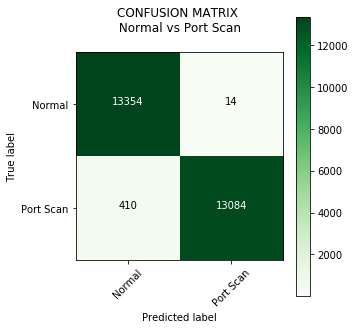

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:176: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


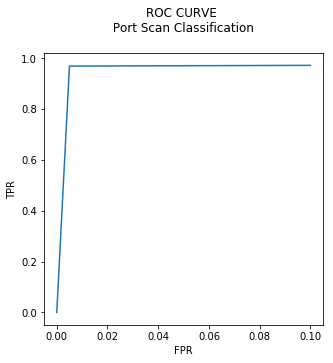

AUC: 0.9842844243029484
Evaluation with selected features using ANOVA
Accuracy:95.6555729283002%
Precison:92.04010640474729
Recall:100.0
F1-Score:95.85508790623335
Confusion matrix, without normalization


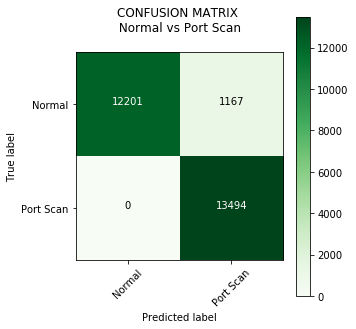

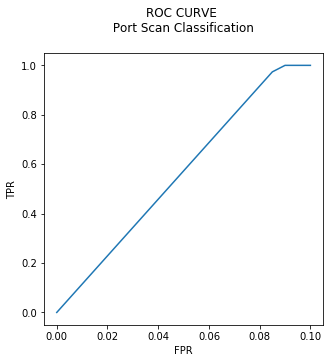

AUC: 0.956350987432675
Evaluation with selected features using RFE
Accuracy:99.09165363710818%
Precison:99.59574786644707
Recall:98.59196680005928
F1-Score:99.09131535826009
Confusion matrix, without normalization


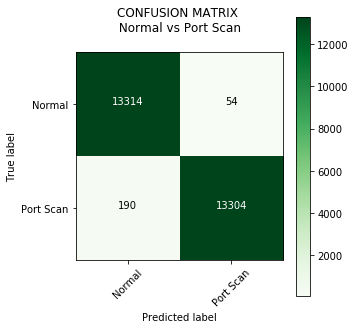

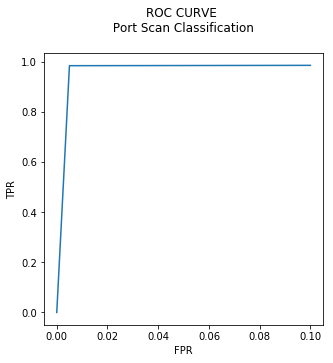

AUC: 0.9909400853467955


In [115]:
#evaluate with all features
print("Evaluation with all features")
evaluate(y_pred_Scan, y_eval_Scan, h_Scan,'Port Scan' )
#evaluate with selected features
print("Evaluation with selected features using ANOVA")
evaluate(y_pred_newScan,y_eval_newScan,h_newScan, 'Port Scan')
#evaluate with selected features
print("Evaluation with selected features using RFE")
evaluate(y_pred_rfeScan,y_eval_rfeScan,h_rfeScan, 'Port Scan')

## DOS

Evaluation with all features
Accuracy:99.99627726900454%
Precison:99.99256892323697
Recall:100.0
F1-Score:99.9962843235611
Confusion matrix, without normalization


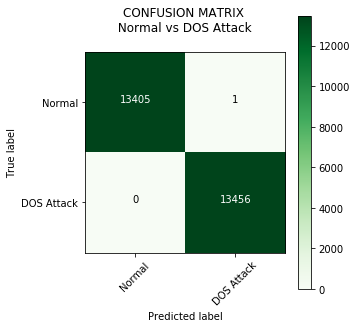

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:176: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


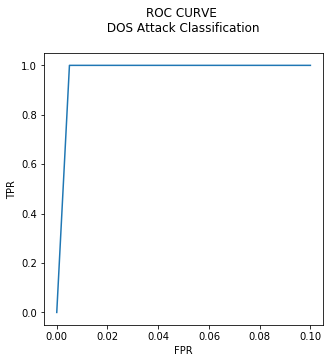

AUC: 0.9999627032671937
Evaluation with selected features using ANOVA
Accuracy:99.99627726900454%
Precison:99.99256892323697
Recall:100.0
F1-Score:99.9962843235611
Confusion matrix, without normalization


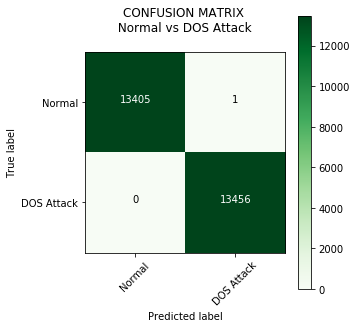

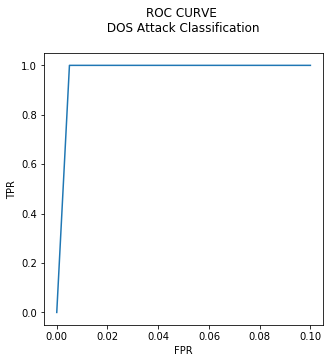

AUC: 0.9999627032671937
Evaluation with selected features using RFE
Accuracy:99.99627726900454%
Precison:99.99256892323697
Recall:100.0
F1-Score:99.9962843235611
Confusion matrix, without normalization


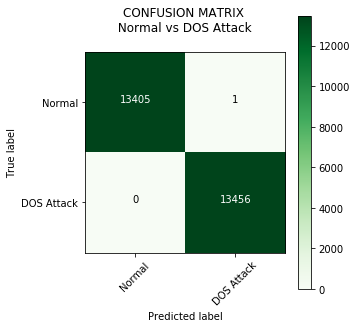

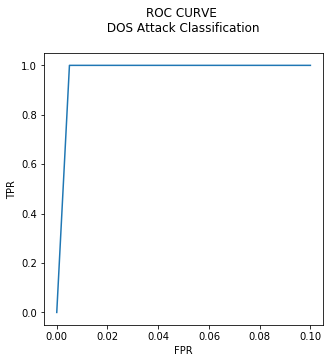

AUC: 0.9999627032671937


In [116]:
#evaluate with all features
print("Evaluation with all features")
evaluate(y_pred_DOS, y_eval_DOS, h_DOS, 'DOS Attack' )
#evaluate with selected features
print("Evaluation with selected features using ANOVA")
evaluate(y_pred_newDOS,  y_eval_newDOS,h_newDOS, 'DOS Attack')
print("Evaluation with selected features using RFE")
evaluate(y_pred_rfeDOS,  y_eval_rfeDOS,h_rfeDOS, 'DOS Attack')

## SSHBruteForce

Evaluation with all features
Accuracy:98.66726230362593%
Precison:97.48790875622609
Recall:99.9260081391047
F1-Score:98.69190295235312
Confusion matrix, without normalization


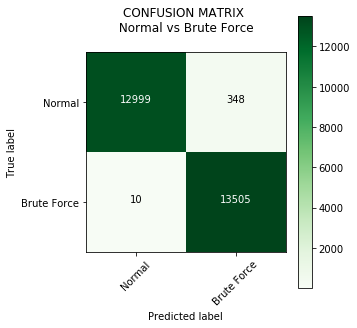

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:176: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


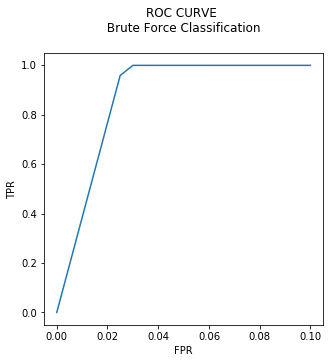

AUC: 0.9865934032489062
Evaluation with selected features using ANOVA
Accuracy:97.90782518055245%
Precison:96.31033249910618
Recall:99.6596374398816
F1-Score:97.95636363636365
Confusion matrix, without normalization


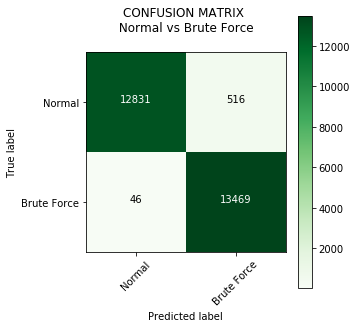

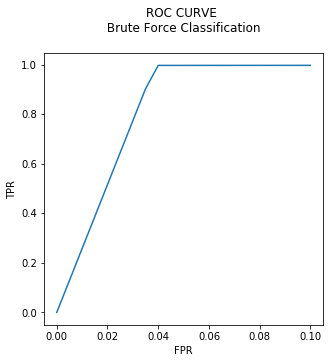

AUC: 0.9789680006406308
Evaluation with selected features using RFE
Accuracy:98.77894423348968%
Precison:98.09614122109564
Recall:99.50425453200148
F1-Score:98.79518072289156
Confusion matrix, without normalization


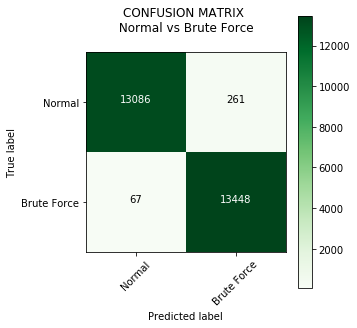

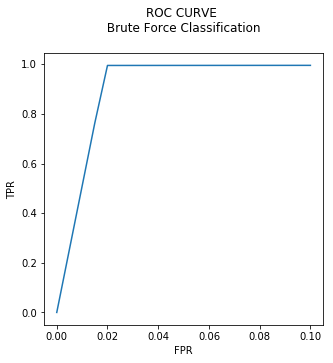

AUC: 0.9877437945750444


In [117]:
#evaluate with all features
print("Evaluation with all features")
evaluate(y_pred_SSHBruteForce , y_eval_SSHBruteForce , h_SSHBruteForce, 'Brute Force' )
#evaluate with selected features
print("Evaluation with selected features using ANOVA")
evaluate(y_pred_newSSHBruteForce,y_eval_newSSHBruteForce,h_newSSHBruteForce , 'Brute Force')
#evaluate with selected features
print("Evaluation with selected features using RFE")
evaluate(y_pred_rfeSSHBruteForce,y_eval_rfeSSHBruteForce,h_rfeSSHBruteForce, 'Brute Force')

## Malware

Evaluation with all features
Accuracy:99.99627726900454%
Precison:99.99256892323697
Recall:100.0
F1-Score:99.9962843235611
Confusion matrix, without normalization


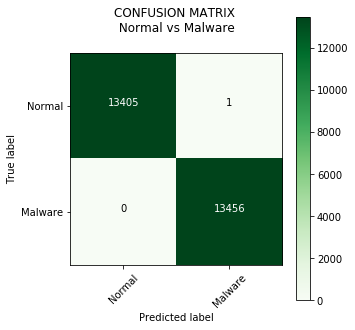

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:176: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


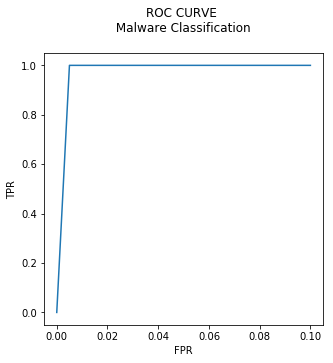

AUC: 0.9999627032671937
Evaluation with selected features using ANOVA
Accuracy:99.99627726900454%
Precison:99.99256892323697
Recall:100.0
F1-Score:99.9962843235611
Confusion matrix, without normalization


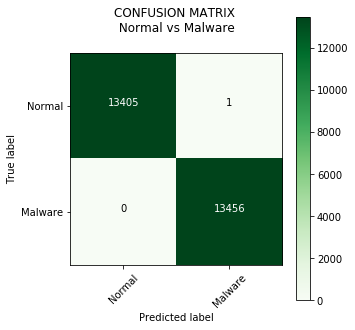

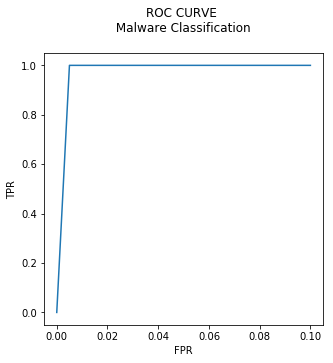

AUC: 0.9999627032671937
Evaluation with selected features using RFE
Accuracy:99.99627726900454%
Precison:99.99256892323697
Recall:100.0
F1-Score:99.9962843235611
Confusion matrix, without normalization


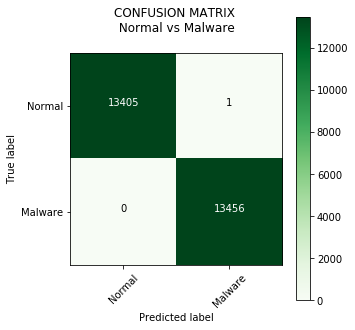

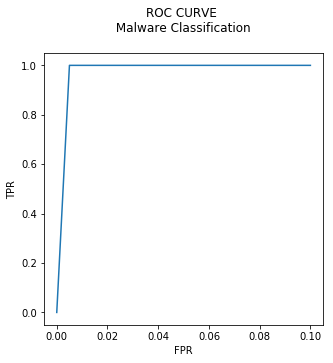

AUC: 0.9999627032671937


In [118]:
#evaluate with all features
print("Evaluation with all features")
evaluate(y_pred_DOS, y_eval_DOS, h_DOS , 'Malware')
#evaluate with selected features
print("Evaluation with selected features using ANOVA")
evaluate(y_pred_newDOS,  y_eval_newDOS,h_newDOS, 'Malware')
#evaluate with selected features
print("Evaluation with selected features using RFE")
evaluate(y_pred_rfeDOS,  y_eval_rfeDOS,h_rfeDOS , 'Malware')


# Multiclass Classification

###   Dense Neural Network

With all the features
              precision    recall  f1-score   support

      Normal       0.98      0.82      0.89     26697
        Scan       0.85      0.97      0.90     13488
         DOS       0.99      1.00      0.99     13484
  Bruteforce       0.87      1.00      0.93     13344
     Malware       0.98      1.00      0.99     13572

    accuracy                           0.93     80585
   macro avg       0.93      0.96      0.94     80585
weighted avg       0.94      0.93      0.93     80585

Accuracy:93.38338400446733%
Confusion matrix, without normalization


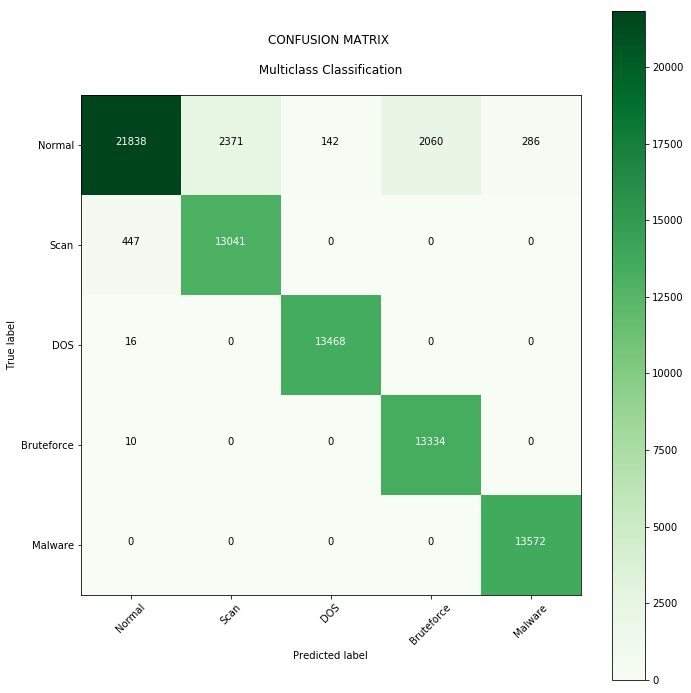

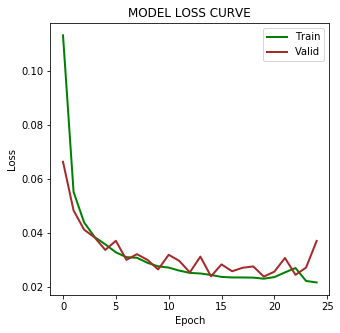

With selected 35 features


NameError: name 'y_pred_dnns' is not defined

In [119]:
print("With all the features")
evaluate_multiclass(y_pred_dnn, y_eval_dnn, h_dnn )
print("With selected 35 features")
evaluate_multiclass(y_pred_dnns, y_eval_dnns, h_dnns )